# Current Population Survey

## Imports

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from operator import itemgetter

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import _tree
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import OneHotEncoder

from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


In [103]:
# sets any scikit transformer to output in a pandas dataframe
set_config(transform_output="pandas")

## Preprocessing

In [104]:
# read in the csv to a df
df = pd.read_csv('final_cps_data.csv')
df.head()

,year,state_fip,state,metro,relation_to_head_of_house,age,gender,race,marital_status,birthplace,...,protective,foodcare,building,sales,office_admin,farmer,construction,production,transport.2,transport.3
0,1990,36,NY,2.0,101,58,1,3,6,NaN,...,0,0,0,0,1,0,0,0,0,0
1,2009,5,AR,2.0,1260,28,1,1,6,9900.0,...,0,0,0,0,1,0,0,0,0,0
2,1990,36,NY,3.0,101,37,1,1,6,NaN,...,0,0,0,0,0,0,0,0,0,0
3,1990,6,CA,3.0,101,34,1,1,6,NaN,...,0,0,0,0,0,0,0,0,0,0
4,1981,51,VA,3.0,101,38,1,4,1,NaN,...,0,0,0,0,0,0,0,0,0,0


In [105]:
# filter dataset to 2013. Prevents YoY changes from negatively impacting our predictions by removing YoY variability
df = df[df['year']==df['year'].max()]

# cleaning out duplicate columns, columns with no mappings (can't translate numbers to categorical) and non-useful columns (all rows have same value)
firstcoldrops = ['year','metro','birthplace','race',
                 'state_fip','longest_job_earnings',
                 'hours_per_week','hourly_wage',
                 'wage_inflation_factor','year_of_immigration',
                 'real_hourly_wage','personal_consumption_expenditure',
                 'occupation_category','family_type','mother_birthplace',
                 'father_birthplace','citizen','foreign_birthplace',
                 'grade_level_achieved','worker_class_last_year',
                 'not_inputed_income','high_school_or_less','bachelors_degree','advanced_degree']

In [106]:
# drop the columns
df = df.drop(firstcoldrops,axis=1)
df.head()


,state,relation_to_head_of_house,age,gender,marital_status,employment_status,worker_class,weeks_worked_last_year,union_member_status,income,...,protective,foodcare,building,sales,office_admin,farmer,construction,production,transport.2,transport.3
20,VT,101,62,1,6,10,21,52,1.0,57000.0,...,0,0,0,0,0,0,0,0,0,0
32,OH,201,59,1,1,10,25,50,0.0,62000.0,...,0,0,0,0,0,0,1,0,0,0
34,RI,101,44,1,1,10,21,52,0.0,45000.0,...,0,0,0,0,0,0,0,0,0,0
36,FL,101,41,1,4,10,21,52,1.0,28000.0,...,0,0,0,0,0,0,0,0,0,0
37,NH,201,35,1,1,10,21,50,0.0,42500.0,...,0,0,0,0,0,0,0,0,0,1


In [107]:
# convert numeric codes to strings
df['relation_to_head_of_house'] = df['relation_to_head_of_house'].map({101:'Head', 
                                                                       201:'Spouse', 
                                                                       301:'Child', 
                                                                       303:'Stepchild', 
                                                                       501:'Parent', 
                                                                       701:'Sibling', 
                                                                       901:'Grandchild', 
                                                                       1001:'Other', 
                                                                       1113:'Partner', 
                                                                       1114:'Unmarried', 
                                                                       1115:'Housemate', 
                                                                       1241:'Roomer', 
                                                                       1242:'Foster', 
                                                                       126:'Other'})

df['marital_status'] = df['marital_status'].map({1:'Married Spouse Present', 
                                                2:'Married Spouse Absent', 
                                                3:'Separated', 
                                                4:'Divorced', 
                                                5:'Widowed', 
                                                6:'Never Married'})

df['worker_class'] = df['worker_class'].map({21:'Private Sector', 
                                                25:'Federal', 
                                                27:'State', 
                                                28:'Local', 
                                                29:'Unpaid Family Worker'})

df['employment_status'] = df['employment_status'].map({10:'Employed', 
                                                12:'Unemployed'})

df['gender'] = df['gender'].map({1:'Male', 
                                2:'Female'})

In [108]:
# convert our target variable into a few bins and make it categorical
# we base this on tax brackets for single filers (US 2022, https://www.nerdwallet.com/article/taxes/federal-income-tax-brackets)
# for the three highest brackets we just bucket them together since they're so few
df['income_cats'] = pd.cut(df['income'],bins=[0,10275,41775,90875,170050,100000000],
                           right=True,
                           labels=['Lowest',
                                'Low',
                                'Medium',
                                'Medium-High',
                                'High'])

#drop the old column
df = df.drop('income',axis=1)

## Train Test Split

In [109]:
# set our target
TARGET = 'income_cats'

# create our X which are our features
X = df.copy()
# remove our target variable
X = X.drop(TARGET,axis=1)



# create our Y which is what we are predicting
Y = df.copy()
Y = Y[TARGET]

# print the shape to make sure that the X and Y 
# have the same number of rows
print(X.shape)
print(Y.shape)



(53790, 59)
(53790,)


In [110]:
# split our data
# keep 80% for training
# keep 20% for testing
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    Y, 
                                                    train_size=0.8,
                                                    test_size=.2,
                                                    stratify=Y)

In [111]:
# 1-hot encode our data
ohe = OneHotEncoder(handle_unknown = 'ignore',sparse_output=False)

# only fit the encoder to the categorical variables
# create a subset of just categorical variables for the train set
X_train_objects = X_train.select_dtypes('object')
# actually fit the encoder
ohe.fit(X_train_objects)

#create a subset of just categorical variables for the test set
X_test_objects = X_test.select_dtypes('object')

# for the training data set transform the categorical then concat it with the numerical
x_train_transformed = pd.concat((ohe.transform(X_train_objects),X_train.select_dtypes(exclude='object')),axis=1)

#do the same for test
x_test_transformed =  pd.concat((ohe.transform(X_test_objects),X_test.select_dtypes(exclude='object')),axis=1)

## All Variables Logistic Regression

In [112]:
# get the coefficients function
# this function just returns a dictionary of the coefficient and the feature
def getCoefLogit( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0],varNames):
        coef_dict[feat] = coef
    return coef_dict

In [113]:
# init the model
# random state of 111 for reproduceability
lr = LogisticRegression(random_state=111)

# fit the model
lr = lr.fit(x_train_transformed,Y_train)

# predict with the model
Y_Pred_Train = lr.predict(x_train_transformed)
Y_Pred_Test = lr.predict(x_test_transformed)

c:\Users\TK\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [114]:
# now return the accuracy of each prediction
train_acc = metrics.accuracy_score(Y_train, Y_Pred_Train)
test_acc = metrics.accuracy_score(Y_test, Y_Pred_Test)

# print the accuracy
print('training accuracy = ', train_acc)
print('testing accuracy = ', test_acc)

training accuracy =  0.591652723554564
testing accuracy =  0.5846811675032534


## Random Forest

Since the logistic regression didn't perform too well. Let's try a random forest

In [115]:
# for the random forest, get the features the model finds important
# returns the feature and the importance score
def getEnsembleTreeVars(ENSTREE, varNames) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average(ENSTREE.feature_importances_) :
            v = int(imp_val / np.max(ENSTREE.feature_importances_) * 100)
            theList.append((varNames[i], v))
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList


In [116]:
# create a random forest instance
# random_state of 111 for reproduceability
rf = RandomForestClassifier(max_depth=5,random_state=111)

# fit it
rf = rf.fit(x_train_transformed,Y_train)

#predict it
rf_ypred_train = rf.predict(x_train_transformed)
rf_ypred_test = rf.predict(x_test_transformed)

In [117]:
# get the accuracy scores
rf_train_acc = metrics.accuracy_score(Y_train, rf_ypred_train)
rf_test_acc = metrics.accuracy_score(Y_test, rf_ypred_test)

# print the accuracy scores
print('training accuracy = ', rf_train_acc)
print('testing accuracy = ', rf_test_acc)

training accuracy =  0.556283695854248
testing accuracy =  0.5476854433909648


In [118]:
# for anonymized feature name + importance score
importances = rf.feature_importances_
feature_names = [f"feature {i}" for i in range(x_train_transformed.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)
forest_importances

feature 0      0.000073
feature 1      0.000142
feature 2      0.000063
feature 3      0.000052
feature 4      0.000116
                 ...   
feature 126    0.001155
feature 127    0.001544
feature 128    0.006242
feature 129    0.001460
feature 130    0.003961
Length: 131, dtype: float64

In [119]:
# get the actual name of the feature + importance score
rf_vars = getEnsembleTreeVars(rf,x_test_transformed.columns.to_list())
print(rf_vars)

[('full_time_job', 100), ('weeks_worked_last_year', 72), ('manager', 37), ('foodcare', 36), ('hisp', 30), ('gender_Female', 29), ('gender_Male', 26), ('white', 19), ('computer', 17), ('marital_status_Married Spouse Present', 15), ('building', 15), ('office_admin', 14), ('age', 12), ('hospitality', 11), ('healthsupport', 10), ('worker_class_Private Sector', 10), ('architect', 9), ('physicians', 9), ('marital_status_Never Married', 8), ('healthcare', 7), ('worker_class_Federal', 6), ('retail_trade', 4), ('public_admin', 4)]


In [120]:
confusion_matrix(Y_test, rf_ypred_test)

array([[   0,   66,    0,  163,    0],
       [   0, 4380,    0,  611,    0],
       [   0,  740,    3,    5,    0],
       [   0, 2301,    0, 1509,    0],
       [   0,  368,    0,  612,    0]], dtype=int64)

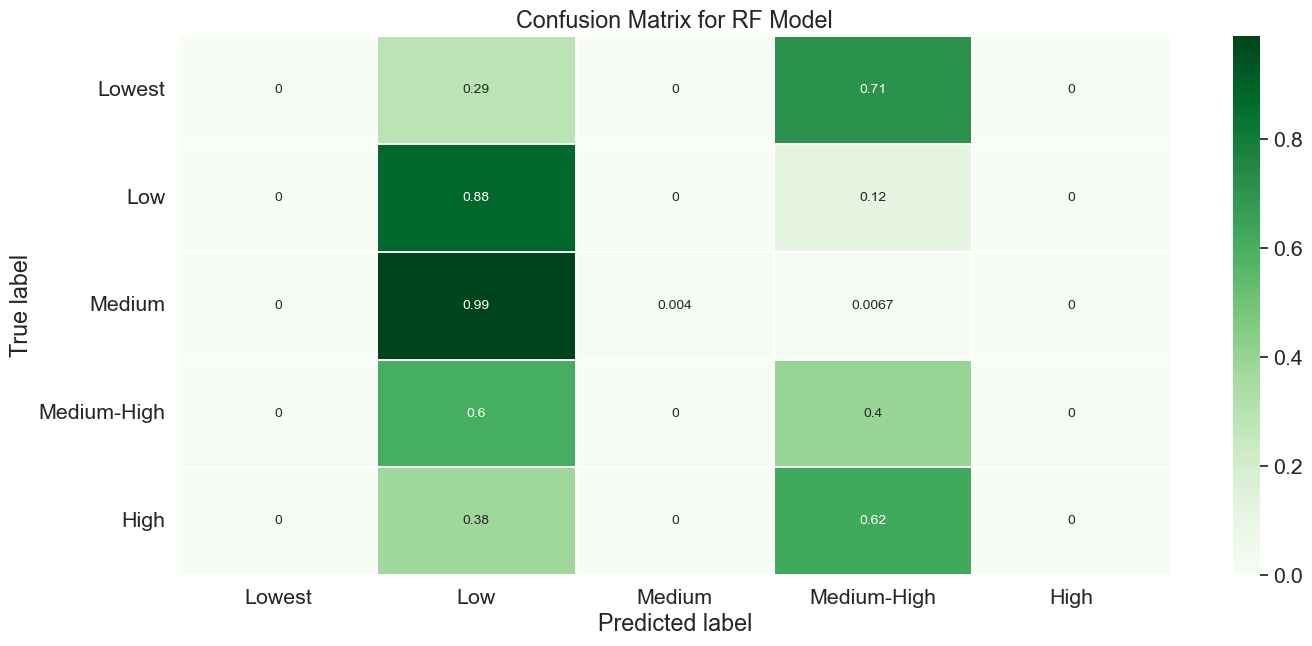

In [121]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(Y_test, rf_ypred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Lowest','Low','Medium','Medium-High','High']
tick_marks = np.arange(len(class_names))+0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for RF Model')
plt.show()

In [123]:
print(classification_report(Y_test, rf_ypred_test))

              precision    recall  f1-score   support

        High       0.00      0.00      0.00       229
         Low       0.56      0.88      0.68      4991
      Lowest       1.00      0.00      0.01       748
      Medium       0.52      0.40      0.45      3810
 Medium-High       0.00      0.00      0.00       980

    accuracy                           0.55     10758
   macro avg       0.42      0.26      0.23     10758
weighted avg       0.51      0.55      0.48     10758



c:\Users\TK\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TK\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TK\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [124]:
set(Y_test) - set(rf_ypred_test)

{'High', 'Medium-High'}

## ROS

In [125]:

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=1)

X_res, y_res = ros.fit_resample(x_train_transformed, Y_train)
y_res.value_counts()

Lowest         19967
Low            19967
Medium         19967
Medium-High    19967
High           19967
Name: income_cats, dtype: int64

In [127]:
# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
# YOUR CODE HERE!
ros_model = LogisticRegression(random_state=1)
# Fit the model using the resampled training data
# YOUR CODE HERE!
ros_model = ros_model.fit(X_res, y_res)
# Make a prediction using the testing data
# YOUR CODE HERE!
ros_training_predictions = ros_model.predict(X_res)

ros_testing_predictions = ros_model.predict(x_test_transformed)



c:\Users\TK\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [128]:
print('train accuracy',metrics.accuracy_score(y_res, ros_training_predictions))
print('test accuracy',metrics.accuracy_score(Y_test, ros_testing_predictions))

train accuracy 0.5167927079681475
test accuracy 0.45361591373861315


In [130]:
# create a random forest instance
# random_state of 111 for reproduceability
rf2 = RandomForestClassifier(max_depth=5,random_state=111)

# fit it
rf2 = rf2.fit(X_res,y_res)

#predict it
rf2_ypred_train = rf2.predict(X_res)
rf2_ypred_test = rf2.predict(x_test_transformed)

In [132]:
# get the accuracy scores
rf2_train_acc = metrics.accuracy_score(y_res, rf2_ypred_train)
rf2_test_acc = metrics.accuracy_score(Y_test, rf2_ypred_test)

# print the accuracy scores
print('training accuracy = ', rf2_train_acc)
print('testing accuracy = ', rf2_test_acc)

training accuracy =  0.546702058396354
testing accuracy =  0.4329801078267336


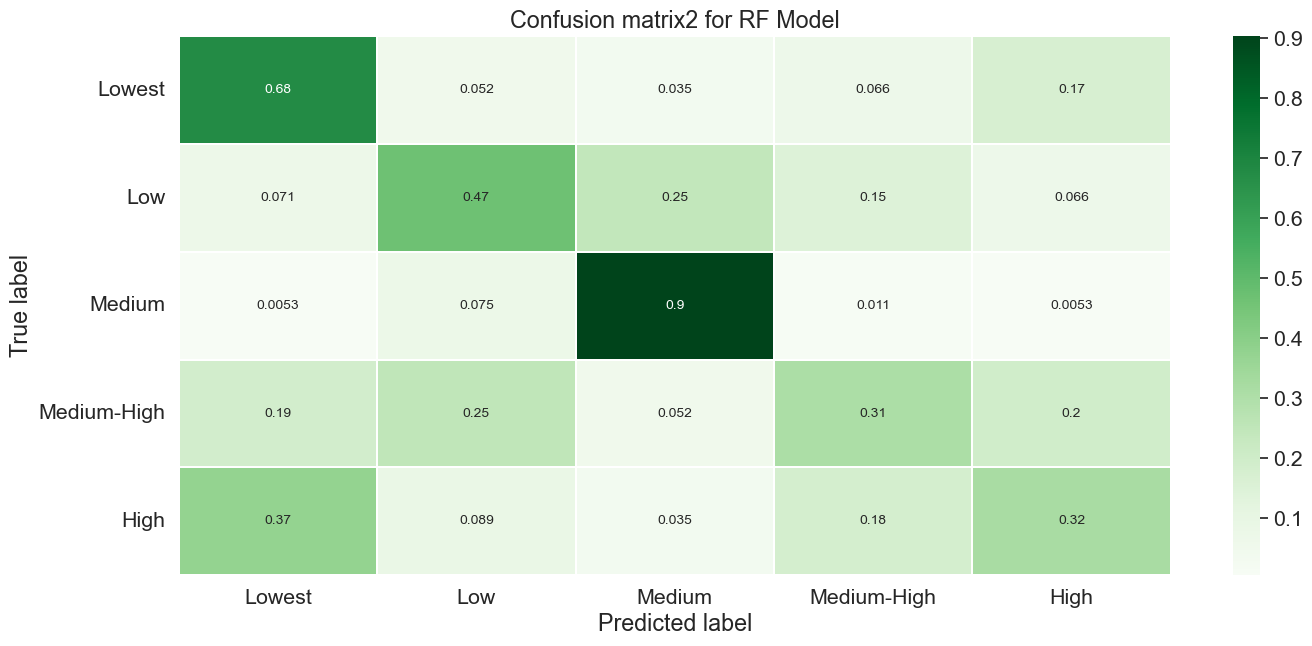

In [133]:
# Get and reshape confusion matrix data
matrix2 = confusion_matrix(Y_test, rf2_ypred_test)
matrix2 = matrix2.astype('float') / matrix2.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix2, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Lowest','Low','Medium','Medium-High','High']
tick_marks = np.arange(len(class_names))+0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix2 for RF Model')
plt.show()

In [135]:
print(classification_report(Y_test, rf_ypred_test))

              precision    recall  f1-score   support

        High       0.00      0.00      0.00       229
         Low       0.56      0.88      0.68      4991
      Lowest       1.00      0.00      0.01       748
      Medium       0.52      0.40      0.45      3810
 Medium-High       0.00      0.00      0.00       980

    accuracy                           0.55     10758
   macro avg       0.42      0.26      0.23     10758
weighted avg       0.51      0.55      0.48     10758



c:\Users\TK\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TK\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\TK\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [134]:
print(classification_report(Y_test, rf2_ypred_test))

              precision    recall  f1-score   support

        High       0.10      0.68      0.17       229
         Low       0.68      0.47      0.55      4991
      Lowest       0.32      0.90      0.47       748
      Medium       0.55      0.31      0.40      3810
 Medium-High       0.22      0.32      0.26       980

    accuracy                           0.43     10758
   macro avg       0.37      0.54      0.37     10758
weighted avg       0.55      0.43      0.46     10758



## Conclusion

Overall, predicting income is quite difficult. The data doesn't seem to have a strong relationship to income either due to the wide reaching nature of the survey or the actual lack of a relationship between the survey questions and income.

Using a plain logistic regression we achieved coin flip levels of accuracy.

Using a plain random forest, we achieved similar accuracy but significantly worse precision/recall/F1.

Combing Random Oversampling with Random forest, we helped the precision/recall/f1 scores but not significantly. 

I think narrowing down the industry would greatly boost our ability to predict income and determine if gender is a significant predictor. Right now there are too many interactions and odd distributions to predict widely, across industries what someone's income will be. We even made income a categorical variable to help the accuracy along since trying to predict it as a numerical target resulted in RMSE's of around $50k which is huge and not very useful. 